# Rice Leaf Disease Detection
---

In [65]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from keras import callbacks
from  keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import splitfolders
import warnings

warnings.filterwarnings("ignore")

---
## Making Subset of Train, Test and Validation

In [66]:
# splitting data and storing them into separate folders as test, train and validation
splitfolders.ratio(r"Data",output="Split Datset",seed=1337,ratio=(0.8,0.1,0.1))

""" 
    Note:-
    Leaf Smut in dataset have 1 image less,i.e, 39 images only. While other both classes have 40 images each.
    To balance that inside Leaf Smut folder copy any image and paste it there itself.
    Now we have 3 classes with equal number of images.  
"""

' \n    Note:-\n    Leaf Smut in dataset have 1 image less,i.e, 39 images only. While other both classes have 40 images each.\n    To balance that inside Leaf Smut folder copy any image and paste it there itself.\n    Now we have 3 classes with equal number of images.  \n'

In [67]:
# storing paths into variables
train_path = r"Split Datset\train"
test_path = r"Split Datset\test"
val_path = r"Split Datset\val"

---
## Generating Training, Testing and Validation Batches Of Images

In [68]:
# data augmentation using Keras’ ImageDataGenerator
train_datagenerator = ImageDataGenerator(
    rescale = (1./255),
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

val_datagenenerator = ImageDataGenerator(rescale=(1./255))

test_datagenerator = ImageDataGenerator(rescale=(1./255))

train = train_datagenerator.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 16,
    color_mode = "rgb",
    class_mode = "categorical"
)

val = val_datagenenerator.flow_from_directory(
    val_path,
    target_size = (224,224),
    batch_size = 16,
    color_mode = "rgb",
    class_mode = "categorical"
)

test = test_datagenerator.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 16,
    color_mode = "rgb",
    class_mode = "categorical"
)

Found 96 images belonging to 3 classes.
Found 12 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [69]:
train.samples

96

---
## Plotting Test Images With Labels

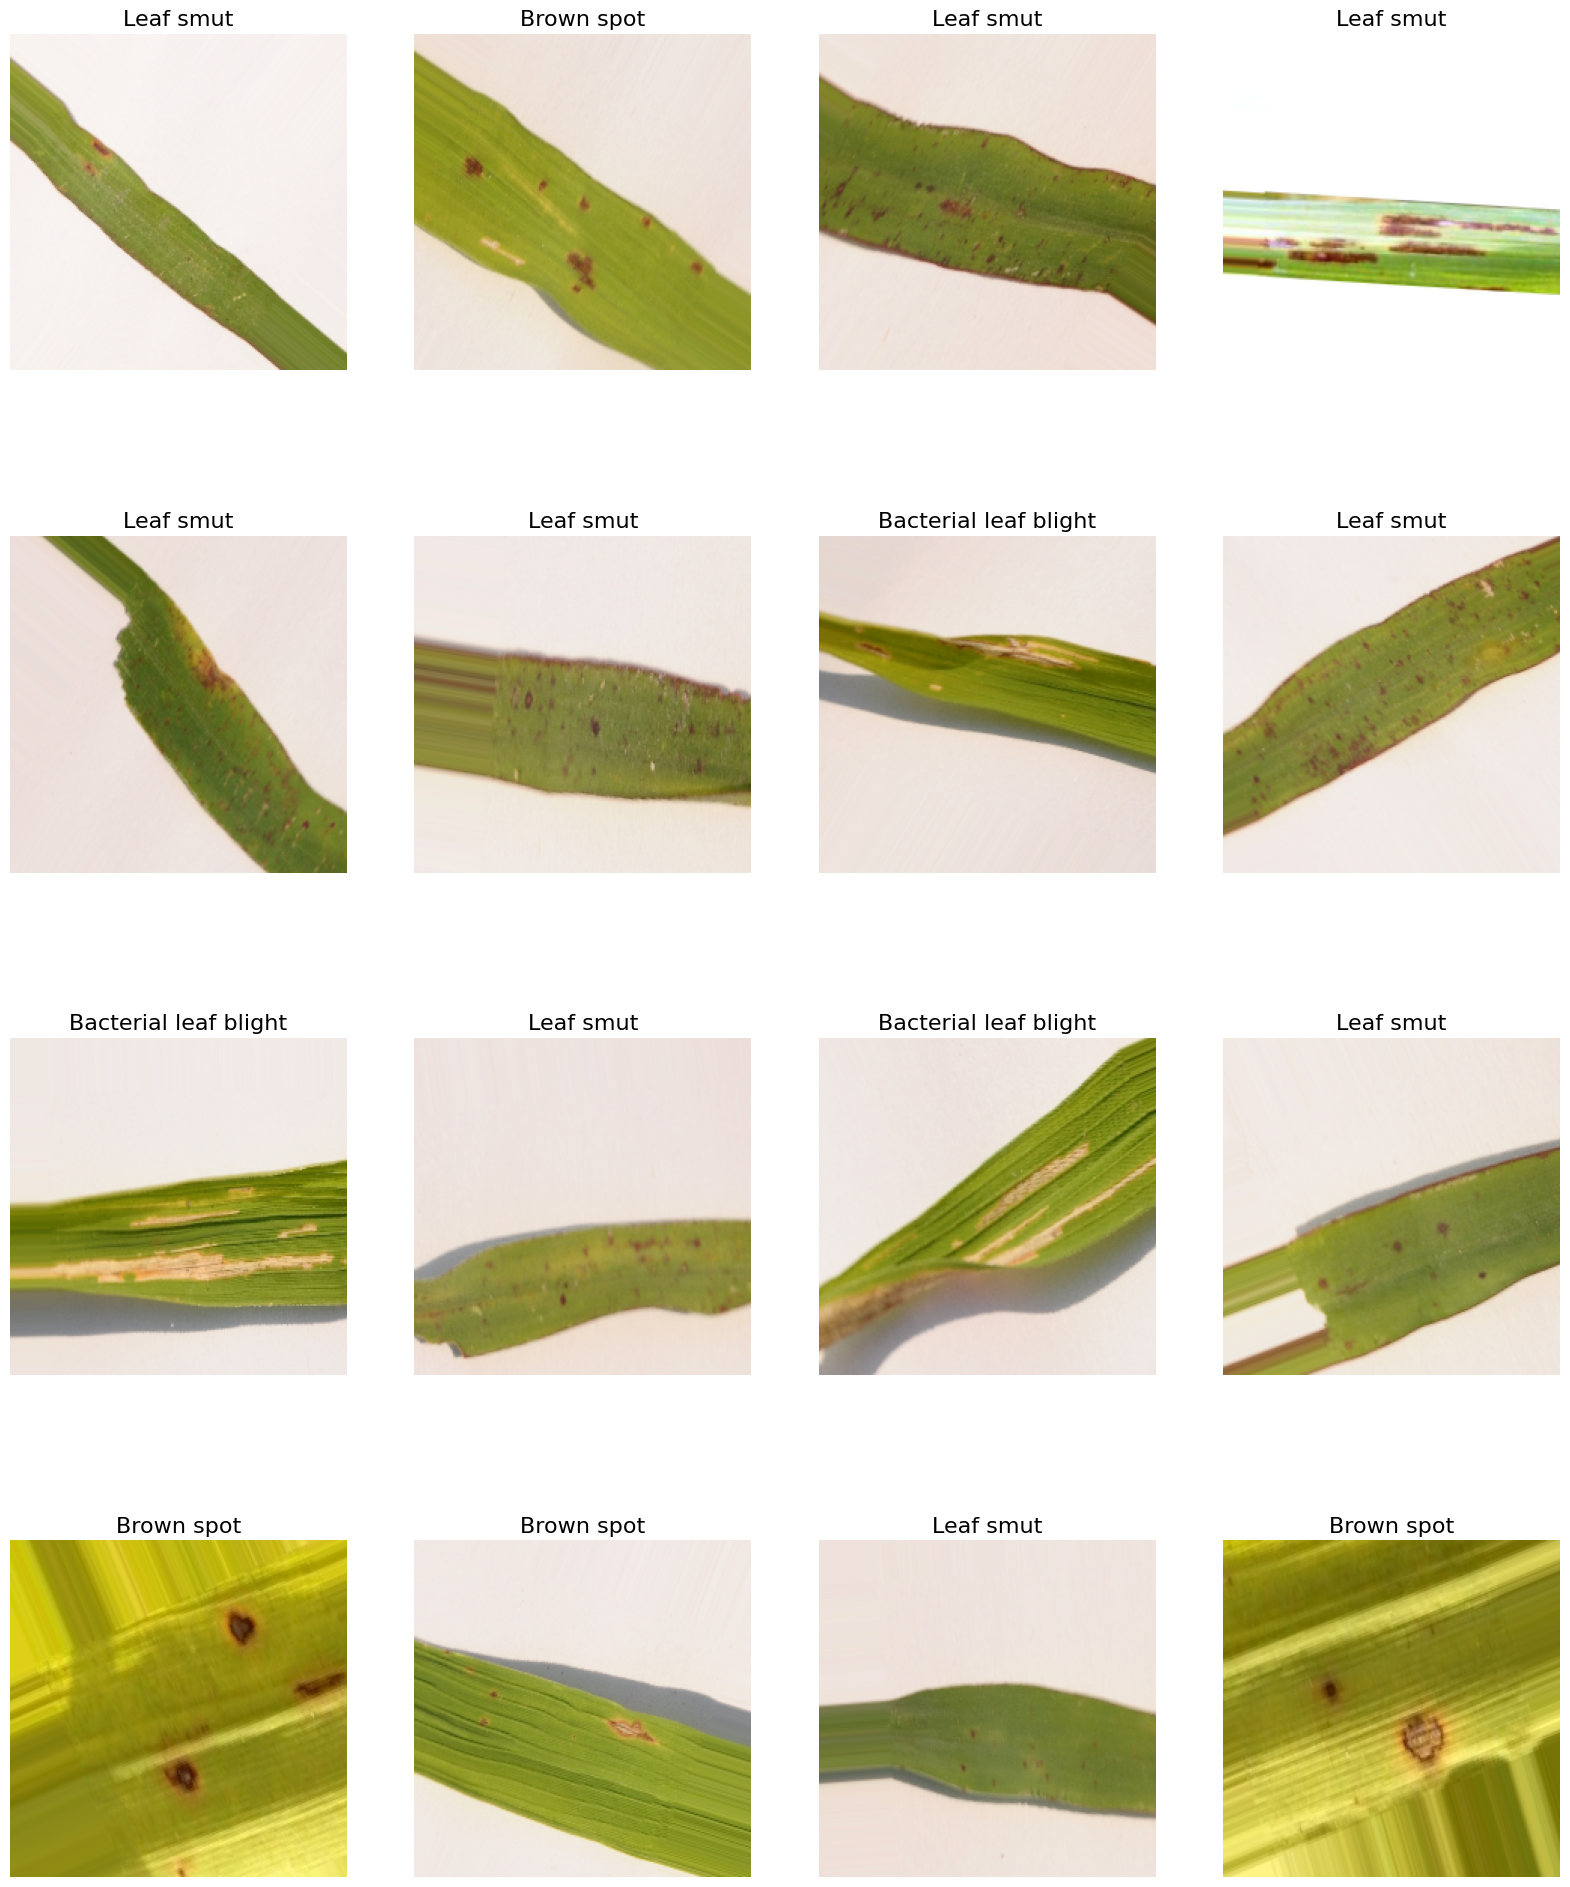

In [70]:
# plotting train images with their labels
def plots(ims, figsize=(20,25), rows=4, interp = False, title = None):
    f = plt.figure(figsize=figsize)
    cols = len(ims) // rows if len(ims) % 2 ==0 else len(ims) // rows+1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        sp.set_title(class_names[title[i].tolist().index(1)],fontsize=16)
        plt.imshow(ims[i])

class_names = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

imgs, labels = next(train)
plots(imgs, title = labels)

---
## Creating CNN Model

In [154]:
from keras.layers import LeakyReLU  

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(224,224,3), name="Conv_1"))
model.add(LeakyReLU(alpha=0.1)) 
model.add(MaxPooling2D(pool_size=(2,2), name="MaxPooling_1"))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", name="Conv_2"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2), name="MaxPooling_2"))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", name="Conv_3"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2), name="MaxPooling_3"))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", name="Conv_4"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2), name="MaxPooling_4"))

model.add(Flatten(name="Flatten"))

model.add(Dropout(0.2, name="Dropout1"))

model.add(Dense(100, activation="relu", name="Dense2"))

model.add(Dropout(0.2, name="Dropout2"))

model.add(Dense(3, activation="softmax", name="Output"))

model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_80 (LeakyReLU)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_1 (MaxPooling2D)     │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_81 (LeakyReLU)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_2 (MaxPooling2D)     │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_82 (LeakyReLU)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_3 (MaxPooling2D)     │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_4 (Conv2D)                 │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_83 (LeakyReLU)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_4 (MaxPooling2D)     │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 100)            │     5,017,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,406,419 (20.62 MB)

 Trainable params: 5,406,419 (20.62 MB)

 Non-trainable params: 0 (0.00 B)

In [155]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

---
## Model Training

In [156]:
history = model.fit(
    train,
    epochs = 100,
    validation_data = val,
    callbacks=[                           
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,       
                restore_best_weights=True,  
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,        
                patience=5,        
                min_lr=1e-7,
                verbose=1
            )
        ]
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4186 - loss: 1.7466WARNING:tensorflow:5 out of the last 451 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x000001EEC7FE6840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 622ms/step - accuracy: 0.3854 - loss: 1.5830 - val_accuracy: 0.4167 - val_loss: 1.0966 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 583ms/step - accuracy:

In [157]:
# Saving the model
model.save("model.keras")

---
## Model Evaluation

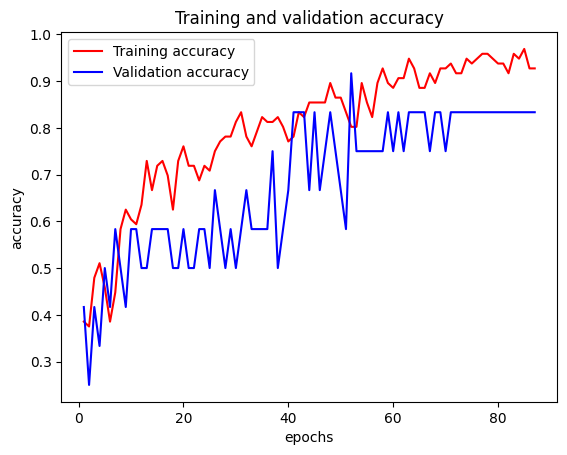

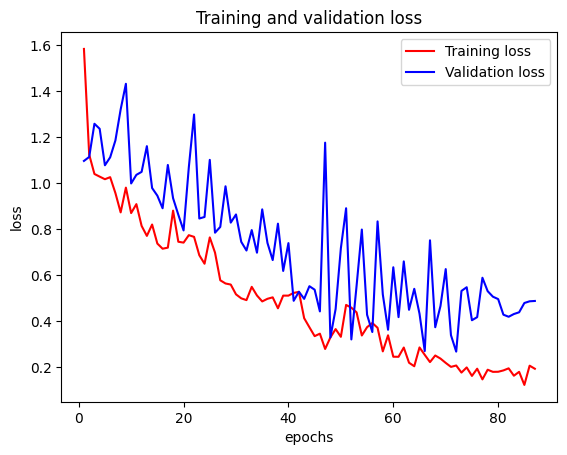

In [158]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

----
## Loading Saved Model 
> It is an optional step, but it is included here to demonstrate that the model has been stored correctly and is functioning properly.

In [159]:
model1 = load_model("model.keras")
model1.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_80 (LeakyReLU)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_1 (MaxPooling2D)     │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_81 (LeakyReLU)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_2 (MaxPooling2D)     │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv2D)                 │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_82 (LeakyReLU)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_3 (MaxPooling2D)     │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_4 (Conv2D)                 │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_83 (LeakyReLU)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_4 (MaxPooling2D)     │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 100)            │     5,017,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,219,259 (61.87 MB)

 Trainable params: 5,406,419 (20.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,812,840 (41.25 MB)

---
## Model Testing

In [160]:
loss,accuracy = model1.evaluate(test)
print("Loss : ",loss)
print(f"Accuracy : {accuracy*100}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step - accuracy: 0.7500 - loss: 0.7262
Loss :  0.726235568523407
Accuracy : 75.0%


In [161]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = test.classes              


cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)


print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Confusion Matrix:
[[1 1 2]
 [1 0 3]
 [2 1 1]]

Classification Report:
                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.25      0.25      0.25         4
           Brown_spot       0.00      0.00      0.00         4
            Leaf_smut       0.17      0.25      0.20         4

             accuracy                           0.17        12
            macro avg       0.14      0.17      0.15        12
         weighted avg       0.14      0.17      0.15        12



---
## Visualization of Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


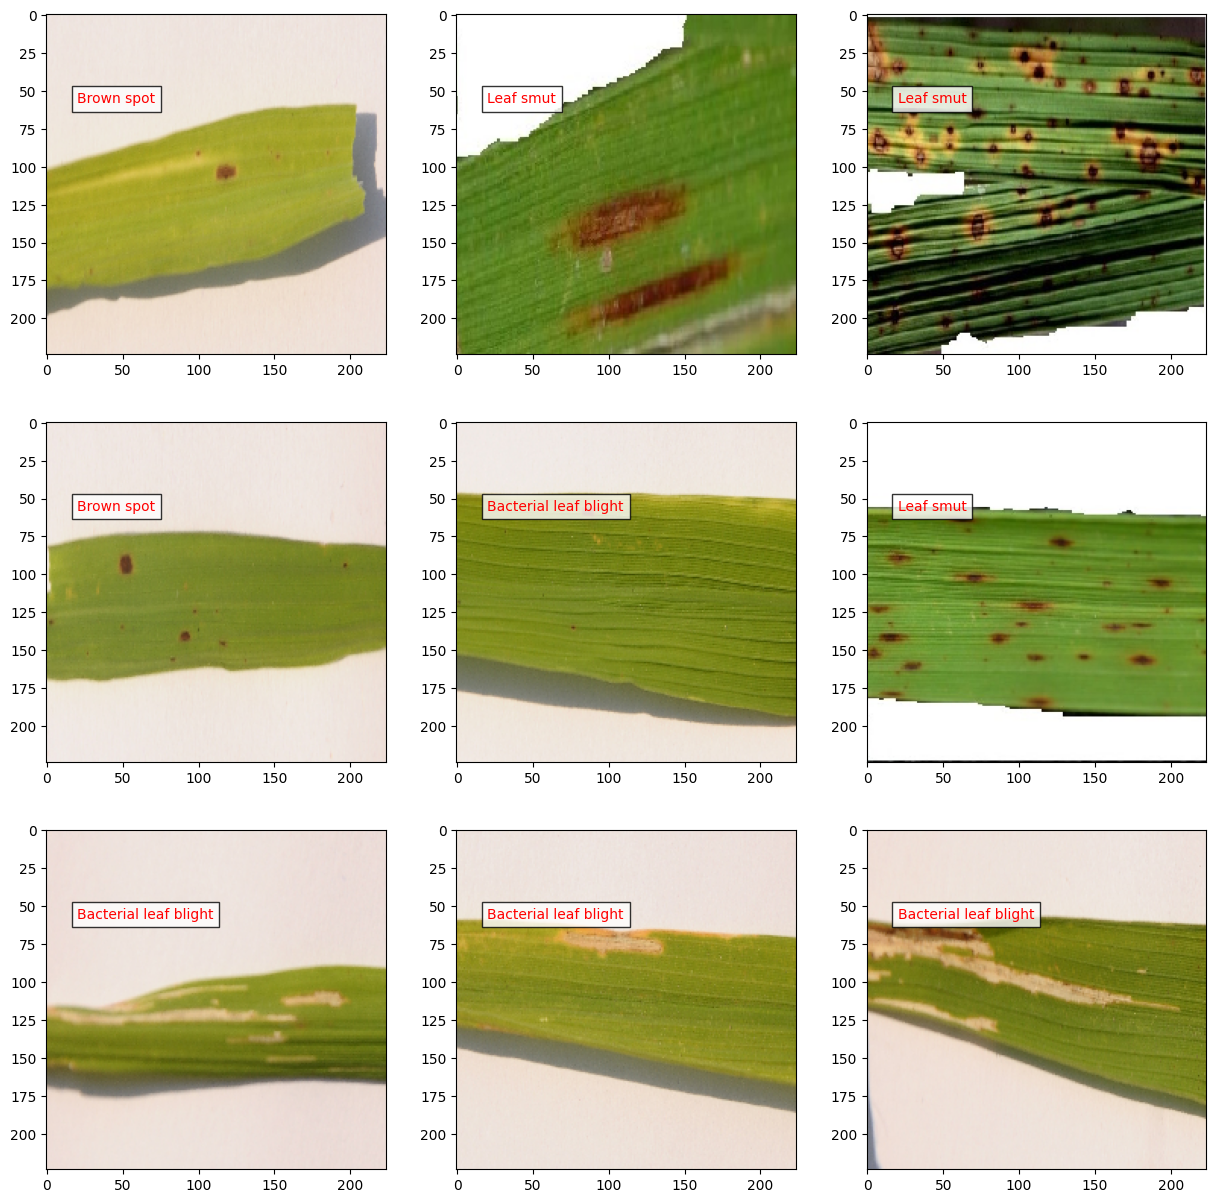

In [162]:
imgs, labels = next(test)
fig =plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img_t = np.expand_dims(imgs[i],axis=0)
    prediction = model1.predict(img_t)
    idx = prediction[0].tolist().index(max(prediction[0]))
    plt.text(20,58, class_names[idx],color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(imgs[i])